In [ ]:
from google.colab import drive
drive.mount('./content/')

Mounted at ./content/


In [ ]:
cd /content/content/MyDrive/Hackathon2021

/content/content/MyDrive/Hackathon2021


In [ ]:
import numpy as np
import tensorflow as tf
# import bz2
from tqdm import tqdm
import re
from sklearn.utils import shuffle

In [ ]:
def reviewToY(review):
    return [1,0] if review.split(' ')[0] == '__label__1' else [0,1] 

def reviewToX(review):
    review = review.split(' ', 1)[1][:-1].lower()
    review = re.sub('\d','0',review)
    if 'www.' in review or 'http:' in review or 'https:' in review or '.com' in review:
        review = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", review)
    return review

def splitReviewsLabels(lines):
    reviews = []
    labels = []
    for review in tqdm(lines):
        rev = reviewToX(review)
        label = reviewToY(review)
        reviews.append(rev[:512])
        labels.append(label)
    return reviews, labels


In [ ]:
with open('AmazonFeedbacks/train.ft.txt', 'r') as f:
  train_lines = f.readlines()

with open('AmazonFeedbacks/test.ft.txt') as f:
  test_lines = f.readlines()

print(len(train_lines), len(test_lines), sep="-->")


3600000-->400000


In [ ]:
reviews_train, y_train = splitReviewsLabels(train_lines)
reviews_test, y_test = splitReviewsLabels(test_lines)
reviews_train, y_train = shuffle(reviews_train, y_train)
reviews_test, y_test = shuffle(reviews_test, y_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

100%|██████████| 400000/400000 [00:06<00:00, 57806.37it/s]


In [ ]:
max_features = 8192
maxlen = 128
embed_size = 64

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#5min
tokenizer = Tokenizer(num_words= max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(reviews_train)

In [ ]:
# tokenizer.word_index

{'<OOV>': 1,
 'the': 2,
 'i': 3,
 'and': 4,
 'a': 5,
 'to': 6,
 'it': 7,
 'of': 8,
 'this': 9,
 'is': 10,
 'in': 11,
 'for': 12,
 'that': 13,
 'was': 14,
 'not': 15,
 'you': 16,
 'but': 17,
 'with': 18,
 'on': 19,
 'book': 20,
 'my': 21,
 'have': 22,
 'as': 23,
 'are': 24,
 '0': 25,
 'one': 26,
 'be': 27,
 'so': 28,
 'great': 29,
 'all': 30,
 'very': 31,
 'good': 32,
 'like': 33,
 'if': 34,
 'they': 35,
 'at': 36,
 'from': 37,
 'just': 38,
 'about': 39,
 'an': 40,
 'out': 41,
 'or': 42,
 'would': 43,
 'has': 44,
 'me': 45,
 '00': 46,
 'what': 47,
 'had': 48,
 'when': 49,
 'read': 50,
 'no': 51,
 'more': 52,
 "it's": 53,
 'up': 54,
 'time': 55,
 'get': 56,
 'by': 57,
 'only': 58,
 'will': 59,
 'there': 60,
 'movie': 61,
 'can': 62,
 'your': 63,
 'he': 64,
 'really': 65,
 'his': 66,
 'some': 67,
 'well': 68,
 "don't": 69,
 'do': 70,
 'first': 71,
 'we': 72,
 'than': 73,
 'them': 74,
 'these': 75,
 'much': 76,
 'after': 77,
 'even': 78,
 'love': 79,
 'who': 80,
 'other': 81,
 'her': 82,
 

In [ ]:
#2m36s
token_train = tokenizer.texts_to_sequences(reviews_train)
token_test = tokenizer.texts_to_sequences(reviews_test)

x_train = pad_sequences(token_train, maxlen=maxlen, padding='post')
x_test = pad_sequences(token_test, maxlen=maxlen, padding='post')

In [ ]:
import gc
del train_lines, test_lines
del reviews_train, reviews_test
del token_train, token_test
gc.collect()

85

In [ ]:
from tensorflow.keras.layers import Flatten
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, Conv1D, GlobalMaxPool1D, Dropout, concatenate, Layer, InputSpec, CuDNNLSTM
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Activation
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import activations, initializers, regularizers, constraints
from keras.utils.conv_utils import conv_output_length
from keras.regularizers import l2
from keras.constraints import maxnorm

In [ ]:
input = Input(shape=(maxlen,))
net = Embedding(max_features, embed_size)(input)
net = Dropout(0.2)(net)
net = BatchNormalization()(net)

net = Conv1D(32, 7, padding='same', activation='relu')(net)
net = BatchNormalization()(net)
net = Conv1D(32, 3, padding='same', activation='relu')(net)
net = BatchNormalization()(net)
net = Conv1D(32, 3, padding='same', activation='relu')(net)
net = BatchNormalization()(net)
net = Conv1D(32, 3, padding='same', activation='relu')(net)
net1 = BatchNormalization()(net)

net = Conv1D(2, 1)(net)
net = GlobalAveragePooling1D()(net)
output = Activation('softmax')(net)
model = Model(inputs = input, outputs = output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

The following Variables were used a Lambda layer's call (tf.compat.v1.nn.conv1d), but
are not present in its tracked objects:
  <tf.Variable 'conv1d/kernel:0' shape=(7, 64, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add), but
are not present in its tracked objects:
  <tf.Variable 'conv1d/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.conv1d_1), but
are not present in its tracked objects:
  <tf.Variable 'conv1d_1/kernel:0' shape=(3, 32, 32) dtype=float32>
It is possible that this is intended behav

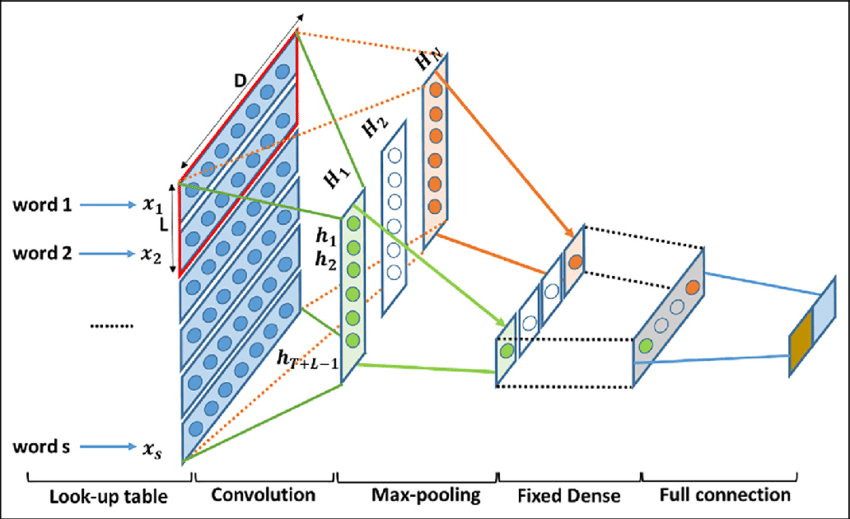

In [ ]:
# weight_path="early_weights.h5"
# checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=5)
# callbacks = [checkpoint, early_stopping]

In [ ]:
# model.fit(x_train, y_train, batch_size=2048, epochs=1, validation_split=0.1)

1583/1583 [==============================] - 114s 72ms/step - loss: 0.5556 - acc: 0.8062 - val_loss: 0.5150 - val_acc: 0.8061


In [ ]:
# model.evaluate(x_test,y_test)

12500/12500 [==============================] - 38s 3ms/step - loss: 0.5151 - acc: 0.8057


[0.5151039958000183, 0.8057050108909607]

In [ ]:
# model.save_weights(weight_path)

In [ ]:
model.load_weights("early_weights.h5")

In [ ]:
model.evaluate(x_test,y_test)

12500/12500 [==============================] - 116s 9ms/step - loss: 0.6952 - acc: 0.4949


[0.6952419281005859, 0.49488750100135803]

In [ ]:
def predict_string(feedbacks):
  prediction_data = feedbacks
  prediction_vector = tokenizer.texts_to_sequences([prediction_data])
  prediction_vector = pad_sequences(prediction_vector,maxlen=maxlen)
  results = model.predict([prediction_vector])
  if results[0] > results[1]:
    print('Unsatisfied')
  else:
    print('Satisfied')

In [ ]:
predict_string("A complete Bust: This game requires quicktime 5.0 to work...if you have a better version of quicktime (I have 7.5), it will ask you to install the quicktime available on the CD...if you click no, it will not let you play. So, I begrudgingly clicked yes on the third try, and it installed quicktime 5, THEN it tells me to please install the quicktime available on the disc. It KEPT telling me that, even after I uninstalled my version of quicktime 7.5, and reinstalled Barbie Rapunzel and quicktime 5. Very frustrating, and the game absolutely will not work for me. It keeps telling me over and over, to install quicktime 5, tho I've been through the installation process repeatedly. It is NOT my operating system limitations. This is a brand new computer...merely weeks old with all the state of the art contraptions.")

array([[0.7002148, 0.2997852]], dtype=float32)